In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
import collections
import os, sys

from tempfile import gettempdir

import math, random
import numpy as np

import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from tensorflow.contrib.tensorboard.plugins import projector

In [4]:
def read_file(filename, zipped=False):
    """Extract the first file enclosed in a zip file as a list of words."""
    if zipped:
        import zipfile
        with zipfile.ZipFile(filename) as f:
            data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    else:
        with open(filename,"r") as f:
            data = tf.compat.as_str(f.read()).split()
    return list(set(data))

In [5]:
vocabulary = read_file("data/text8")

### Step 2: Build the dictionary and replace rare words with UNK token.

In [6]:
vocabulary_size = min(50000, len(vocabulary))

In [7]:
def build_dataset(words, n_words):
    """Process raw inputs into a dataset"""
    counts = [['UNK', -1]]
    counts.extend(collections.Counter(words).most_common(n_words-1))
    dictionary=dict()
    for word, _ in counts:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 0)
        if index==0:
            unk_count+=1
        data.append(index)
    counts[0][1]=unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, counts, dictionary, reversed_dictionary

In [8]:
data, count, dictionary, reverse_dictionary = build_dataset(vocabulary, vocabulary_size)

In [9]:
del vocabulary  # Hint to reduce memory.

In [10]:
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

Most common words (+UNK) [['UNK', 203855], ('caprotinae', 1), ('nyima', 1), ('intracavity', 1), ('nivison', 1)]
Sample data [1, 2, 3, 4, 5, 31288, 6, 0, 7, 10] ['caprotinae', 'nyima', 'intracavity', 'nivison', 'orienting', 'elmers', 'jeunesse', 'UNK', 'wonderworld', 'baronetcy']


### Generate training batch for Skip-gram model

In [11]:
data_index = 0
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window  # subsampling

    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)

    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    buffer.extend(data[data_index:data_index + span])
    if data_index + span > len(data):
        data_index = 0
    data_index += span

    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window]  # target word
            labels[i * num_skips + j, 0] = buffer[context_word]

        if data_index == len(data):
            buffer.extend(data[0:span])
            data_index = span
        else:
            buffer.append(data[data_index])
            data_index += 1
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)

    return batch, labels


In [12]:
batch, labels = generate_batch(batch_size=8, num_skips=4, skip_window=2)

In [13]:
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0],
        reverse_dictionary[labels[i, 0]])

3 intracavity -> 2 nyima
3 intracavity -> 1 caprotinae
3 intracavity -> 5 orienting
3 intracavity -> 4 nivison
4 nivison -> 3 intracavity
4 nivison -> 5 orienting
4 nivison -> 2 nyima
4 nivison -> 31288 elmers


### build and train a skip-gram model

In [14]:
batch_size = 32
embedding_size = 32
skip_window = 1
num_skips = 2  # How many times to reuse an input to generate a label.
num_sampled = 16  # Number of negative examples to sample.

In [15]:
# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. These 3 variables are used only for
# displaying model accuracy, they don't affect calculation.
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

In [23]:
graph = tf.Graph()

with graph.as_default():
    
    # Input data
    
    with tf.name_scope("inputs"):
        train_inputs = tf.placeholder(tf.int32, shape=[batch_size])  # ids of the target words
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
        
        valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
        
        with tf.device("/gpu"):
            
            # Lookup embeddings for inputs
            with tf.name_scope("embeddings"):
                embeddings = tf.Variable(
                    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
                
                # quick way to get the words corresponding to a vector
                embed = tf.nn.embedding_lookup(embeddings, train_inputs)
                
                # Noise Contrastive Estimation
                nce_weights = tf.Variable(
                    tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0/math.sqrt(embedding_size)))
            with tf.name_scope("bias"):
                nce_bias = tf.Variable(
                    tf.zeros([embedding_size]))
                
        with tf.name_scope("loss"):
            loss = tf.reduce_mean(
                tf.nn.nce_loss(
                    weights=nce_weights,
                    biases=nce_bias,
                    labels=train_labels,
                    inputs=embed,
                    num_sampled=num_sampled,
                    num_classes=vocabulary_size
                )
            )
    # Add the loss value as a scalar to summary.
    tf.summary.scalar('loss',loss)
    
    # Construct the SGD optimizer using a learning rate of 0.1
    with tf.name_scope('optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
        
    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings/norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
    
    merged = tf.summary.merge_all()
    
    # Add variable initializer.
    init = tf.global_variables_initializer()
    
    # Create a saver
    saver = tf.train.Saver()
    
    # Begin training
    num_steps = 1001
    
    with tf.Session(graph=graph) as session:
        # Open a writer to write summaries.
        writer = tf.summary.FileWriter("out", session.graph)
        with tf.device("/gpu"):
            # We must initialize all variables before we use them.
            init.run()
            print("Variables initialized")

            average_loss = 0
            for step in range(num_steps):
                batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)

                feed_dict = {train_inputs:batch_inputs, train_labels:batch_labels}

                # Define metadata variable.
                run_metadata = tf.RunMetadata()

                # We perform one update step by evaluating the optimizer op (including it
                # in the list of returned values for session.run()
                # Also, evaluate the merged op to get all summaries from the returned "summary" variable.
                # Feed metadata variable to session for visualizing the graph in TensorBoard.
                _, summary, loss_val = session.run([optimizer, merged, loss],
                                                   feed_dict=feed_dict,
                                                   run_metadata=run_metadata)
                average_loss += loss_val

                writer.add_summary(summary, step)

                # Add metadata to visualize the graph for the last run.
                if step == (num_steps - 1):
                    writer.add_run_metadata(run_metadata, 'step%d' % step)

                if step % 100 == 0:
                    if step > 0:
                        average_loss /= 100
                    # The average loss is an estimate of the loss over the last 100 batches.
                    print('Average loss at step ', step, ': ', average_loss)
                    average_loss = 0

#                 if step % 100 == 0:
#                     sim = similarity.eval()
#                     for i in range(valid_size):
#                         valid_word = reverse_dictionary[valid_examples[i]]
#                         top_k = 8  # number of nearest neighbors
#                         nearest = (-sim[i, :]).argsort()[1:top_k + 1]
#                         log_str = 'Nearest to %s:' % valid_word
#                         for k in range(top_k):
#                             close_word = reverse_dictionary[nearest[k]]
#                             log_str = '%s %s,' % (log_str, close_word)
#                             print(log_str)
                final_embeddings = normalized_embeddings.eval()

                # Write corresponding labels for the embeddings.
                with open("out" + '/metadata.tsv', 'w') as f:
                    for i in range(vocabulary_size):
                        f.write(reverse_dictionary[i] + '\n')


                # Save the model for checkpoints.
                saver.save(session, os.path.join("out", 'model.ckpt'))


                # Create a configuration for visualizing embeddings with the labels in TensorBoard.
                config = projector.ProjectorConfig()
                embedding_conf = config.embeddings.add()
                embedding_conf.tensor_name = embeddings.name
                embedding_conf.metadata_path = os.path.join("out", 'metadata.tsv')
                projector.visualize_embeddings(writer, config)

        writer.close()

Variables initialized
Average loss at step  0 :  104.46769714355469
Average loss at step  100 :  80.51648956298828
Average loss at step  200 :  80.024638671875
Average loss at step  300 :  81.92716625213623
Average loss at step  400 :  70.09326515197753
Average loss at step  500 :  62.20348222732544
Average loss at step  600 :  57.95404680252075
Average loss at step  700 :  53.19883498191834
Average loss at step  800 :  51.44439519882202
Average loss at step  900 :  52.07440492630005
Average loss at step  1000 :  48.30740484237671


In [24]:
def plot_with_labels(low_dim_embs, labels, filename):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom')

    plt.savefig(filename)

In [27]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(
  perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])

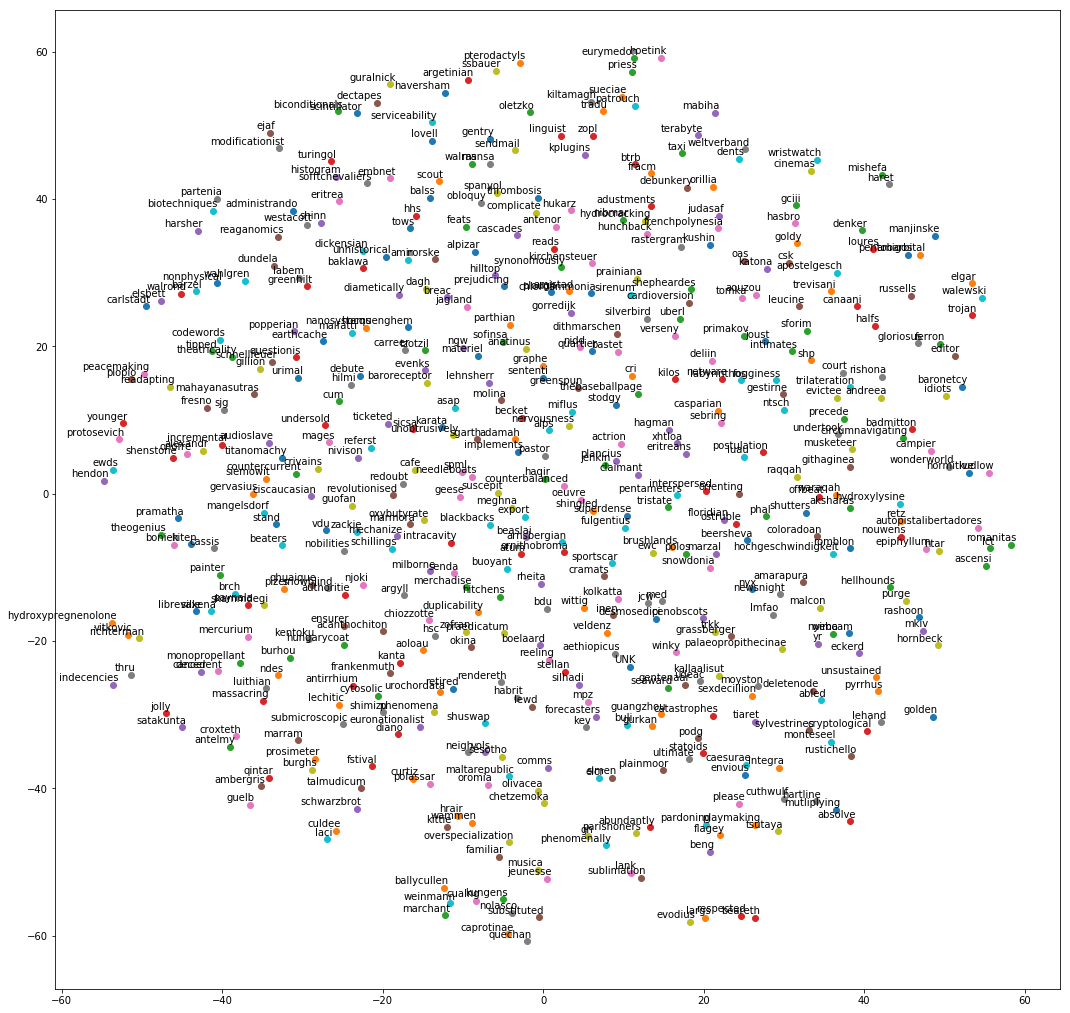

In [26]:
labels = [reverse_dictionary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels, os.path.join(gettempdir(), 'tsne.png'))